In [1]:
import os
import shutil
from pathlib import Path
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv
import ogstools as ot
import ogstools.variables as ov

import matplotlib.pyplot as plt
import numpy as np
import os
from subprocess import run

from meshing import create_fractured_cube_centered

## Path

In [2]:
OGS_PATH = None

if OGS_PATH is not None:
    os.environ["OGS_BIN_PATH"] = OGS_PATH
out_dir = Path(os.environ.get("OGS_TESTRUNNER_out_dir", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)
shutil.rmtree(out_dir, ignore_errors=True)


mesh_dir = out_dir / "mesh"

## 3D mesh

In [3]:

MSH_FILE = mesh_dir / "cube_frac_v.msh"
MSH_FILE.parent.mkdir(parents=True, exist_ok=True)
center_z = -100

create_fractured_cube_centered(
    MSH_FILE,
    lc=10, lc_frac=2, L=50.0, H=50.0, T=50.0,
    theta_deg=0.0, b=4,
    center_z=center_z,
)  # structured mesh : b = 2*lc_frac

assert MSH_FILE.is_file(), f"Mesh not written: {MSH_FILE}"

In [4]:
def export_vtu_sets(msh_file: Path):
    out_dir = msh_file.parent
    if not msh_file.is_file():
        raise FileNotFoundError(f"Mesh not found: {msh_file}")

    meshes_dom = ot.meshes_from_gmsh(msh_file, dim=[3], log=False)
    for name, mesh in meshes_dom.items():
        pv.save_meshio(out_dir / f"{name}.vtu", mesh)


export_vtu_sets(MSH_FILE)

In [5]:
cwd = Path.cwd()
os.chdir(mesh_dir)

run(
    f"NodeReordering -o domain.vtu -i domain.vtu",
    shell=True,
    check=True,
)

run(
    "identifySubdomains -f -m domain.vtu -s 1e-8 -- "
    "physical_group_F_*.vtu  physical_group_L_*.vtu physical_group_CENTER.vtu",
    shell=True,
    check=True,
)

os.chdir(cwd)

[2025-10-09 11:43:01.496] [ogs] [info] Reordering nodes... 
[2025-10-09 11:43:01.509] [ogs] [info] Corrected 0 elements.
[2025-10-09 11:43:01.528] [ogs] [info] VTU file written.
[2025-10-09 11:43:01.596] [ogs] [info] Mesh reading time: 0.020294 s
[2025-10-09 11:43:01.597] [ogs] [info] MeshNodeSearcher construction time: 0.000392 s
[2025-10-09 11:43:01.597] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 5e-06 s
[2025-10-09 11:43:01.597] [ogs] [warning] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_F_BACK' and it is not equal to the newly computed values.
[2025-10-09 11:43:01.597] [ogs] [info] Overwriting 'bulk_node_ids' property.
[2025-10-09 11:43:01.598] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.000915 s
[2025-10-09 11:43:01.598] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 2.1e-05 s
[2025-10-09 11:43:01.598] [ogs] [warning] There is already a 'bulk_node_ids' pro

## Material propertieses

In [6]:
gneiss = {
    "young_sample": 83.9e9,
    "nu_sample": 0.21,
    "biot": 0.6,
    "porosity": 0.001,
    "permeability": 1e-19,
    "density_solid": 2750,
    "w_init": 1e-6,
}

fault = {
    "young_modulus": gneiss["young_sample"],
    "poisson_ratio": gneiss["nu_sample"],
    "biot": gneiss["biot"],
    "porosity": gneiss["porosity"],
    "density": gneiss["density_solid"],
    "permeability": (gneiss["w_init"] ** 2) / 12.0,
}


rho = 1000.0
g = 9.81
pmax = 5e6

## Run OGS

In [7]:
prj_in = Path("HM_init_3D.prj")
prj_out = out_dir / "HM_init_3D_updated.prj"


matrix_mids = [0, 2]
fault_mids = [1]

prj = ot.Project(input_file=prj_in, output_file=prj_out)
prj.replace_parameter_value(name="E1", value=gneiss["young_sample"])
prj.replace_parameter_value(name="nu1", value=gneiss["nu_sample"])

def set_medium_props(mid, biot, k_perm, poro, rho_solid):
    prj.replace_medium_property_value(mediumid=mid, name="biot_coefficient", value=biot)
    prj.replace_medium_property_value(mediumid=mid, name="permeability", value=k_perm)
    prj.replace_medium_property_value(mediumid=mid, name="porosity", value=poro)
    prj.replace_phase_property_value(mediumid=mid, phase="Solid", name="density", value=rho_solid)

for mid in matrix_mids:
    set_medium_props(mid, gneiss["biot"], gneiss["permeability"], gneiss["porosity"], gneiss["density_solid"])

for mid in fault_mids:
    set_medium_props(mid, fault["biot"], fault["permeability"], fault["porosity"], fault["density"])


p0 = rho * g * (-center_z)
m0 = p0 / pmax
m0 = max(0.0, min(1.0, m0))

coords_str = "0 500 600 700 800 900 1000"
vals = [
    m0, m0,
    m0 + (1 - m0) * 0.2,
    m0 + (1 - m0) * 0.4,
    m0 + (1 - m0) * 0.6,
    m0 + (1 - m0) * 0.8,
    1.0
]
values_str = " ".join(f"{v:.6g}" for v in vals)

print(f"center_z = {center_z} m")
print(f"p0 = {p0/1e6:.3f} MPa")
print(f"m0 = {m0:.5f}")
print("coords:", coords_str)
print("values:", values_str)
prj.replace_text("timeRamp", xpath="./curves/curve/name")              
prj.replace_text(coords_str, xpath="./curves/curve/coords")
prj.replace_text(values_str, xpath="./curves/curve/values")
prj.replace_parameter_value(name="p_injection_rate", value=pmax)

prj.replace_text("genesis_HM_init", xpath="./time_loop/output/prefix")
prj.write_input()


center_z = -100 m
p0 = 0.981 MPa
m0 = 0.19620
coords: 0 500 600 700 800 900 1000
values: 0.1962 0.1962 0.35696 0.51772 0.67848 0.83924 1


In [8]:
prj.run_model(logfile=out_dir / "ogs_run.txt",
              #path="~/Code/ogs6/build/release-lis/bin",
              #path="~/Code/ogs6/build/release-petsc/bin",
              args=f"-o {out_dir} -m {mesh_dir}")

Project file written to output.
Simulation: _out/HM_init_3D_updated.prj
Status: finished successfully.
Execution took 1172.7429640293121 s


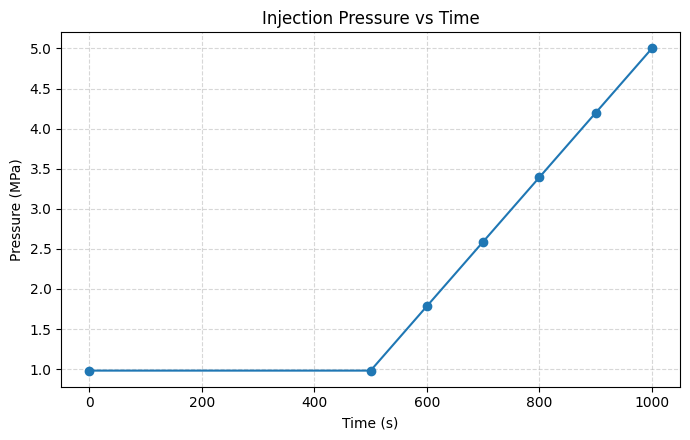

In [21]:
times_s = [float(t) for t in coords_str.split()]

p_MPa = [v * (pmax / 1e6) for v in vals]

plt.figure(figsize=(7, 4.5))
plt.plot(times_s, p_MPa, marker="o")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (MPa)")
plt.title("Injection Pressure vs Time")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Post-processing

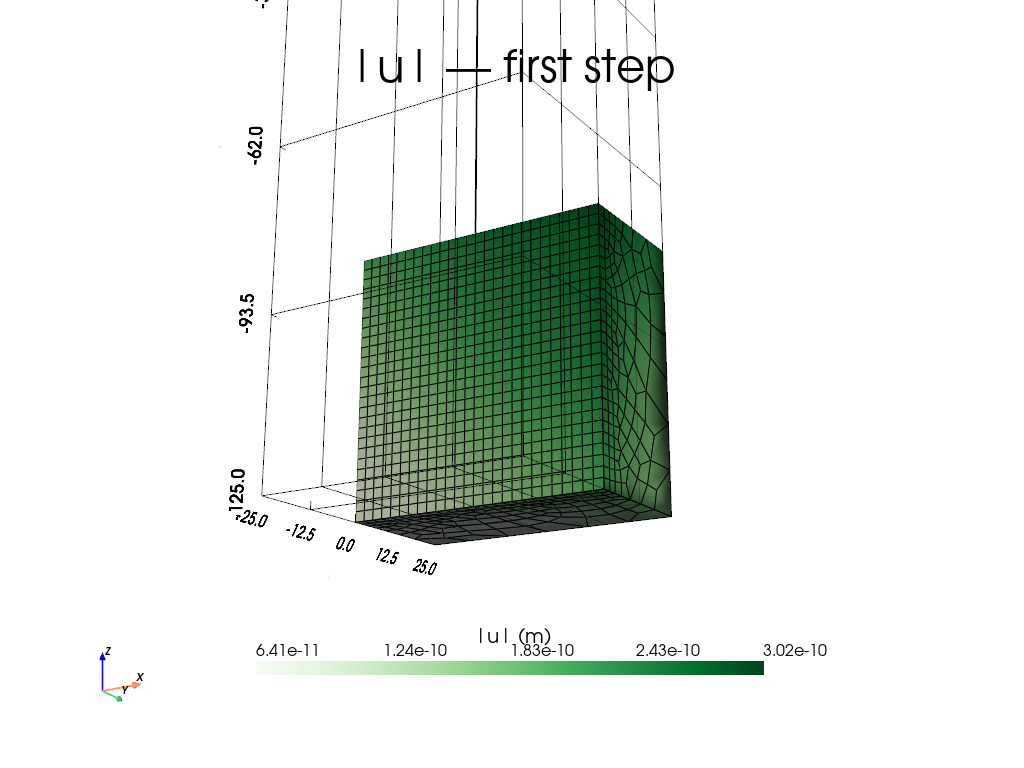

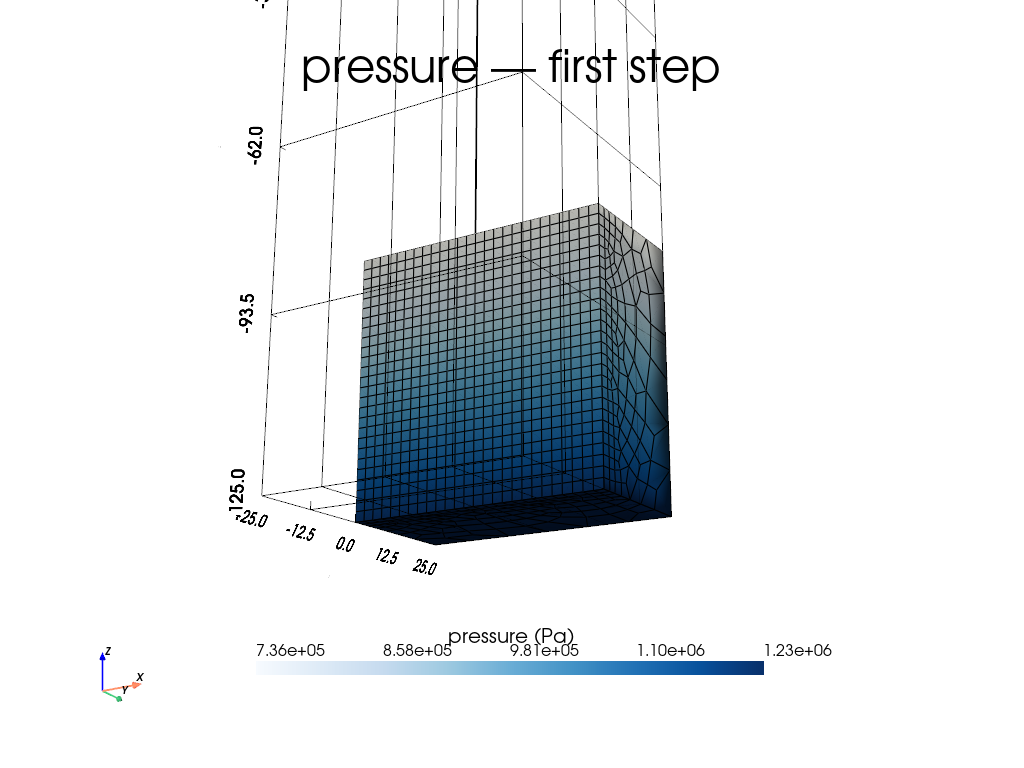

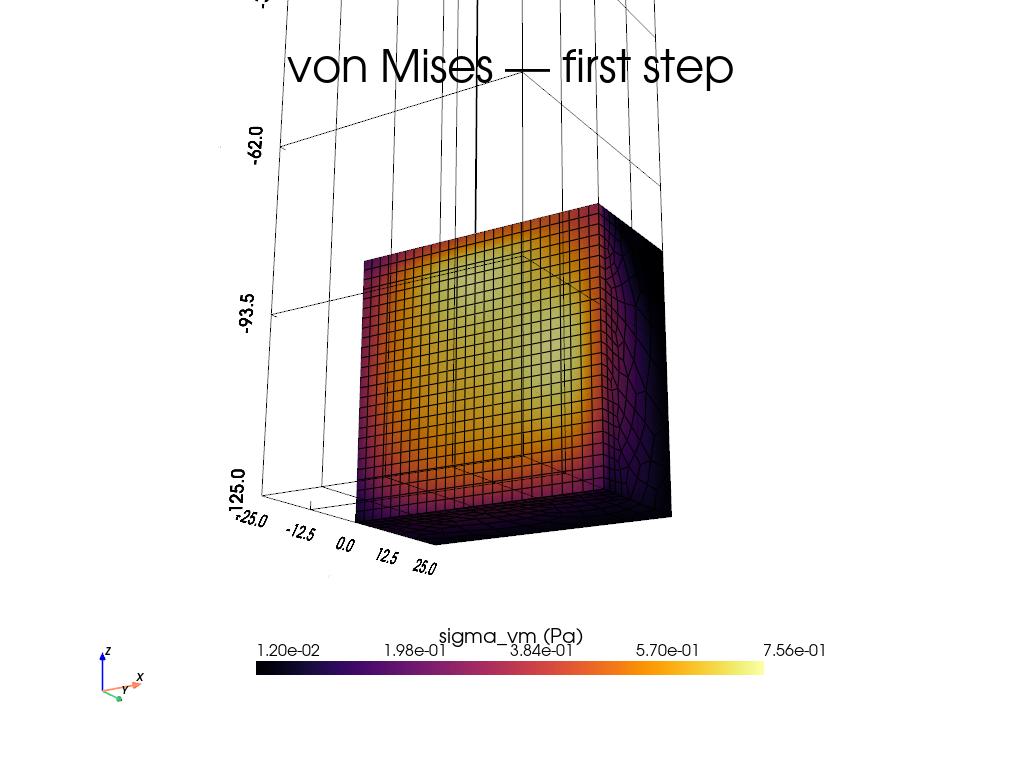

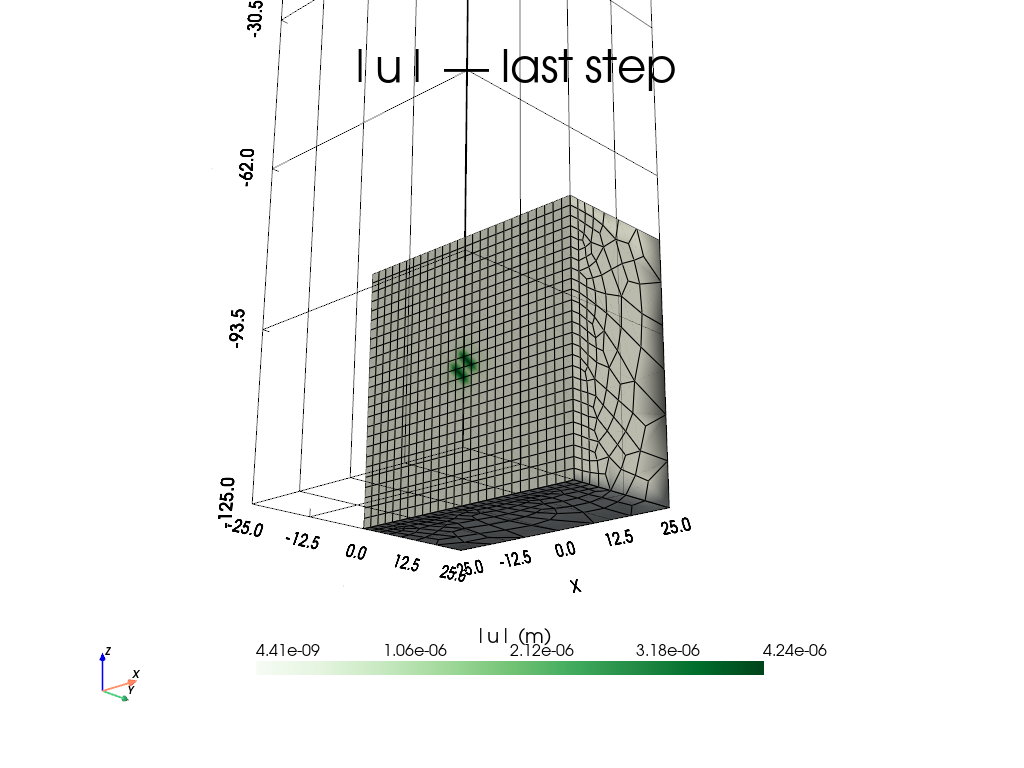

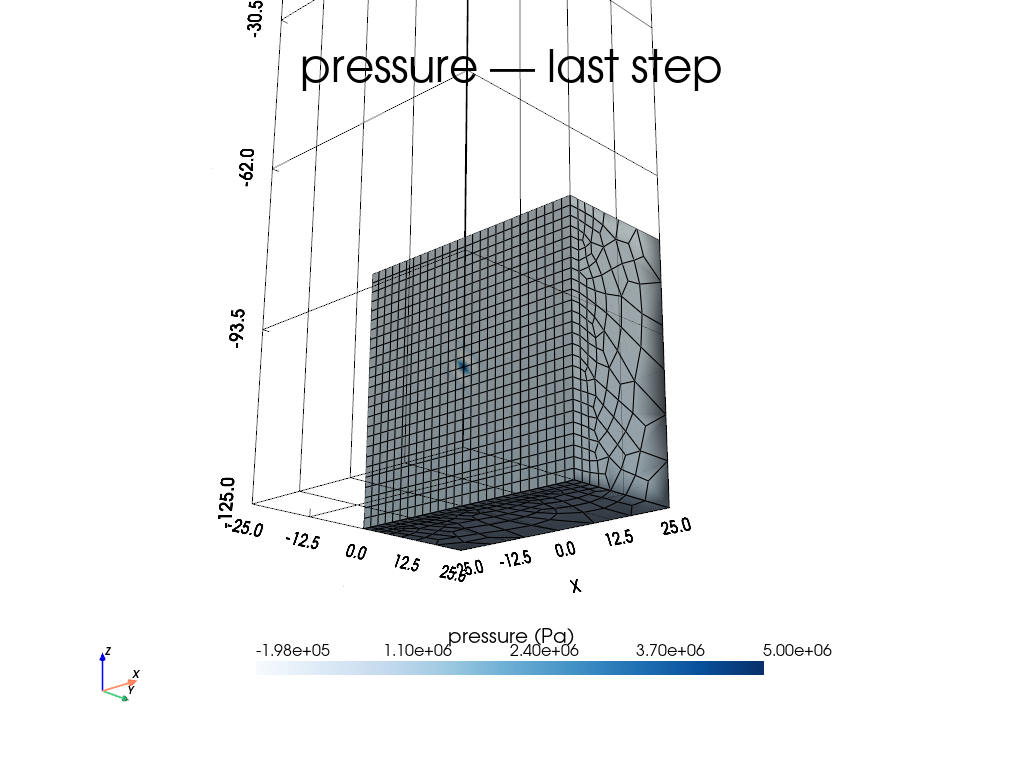

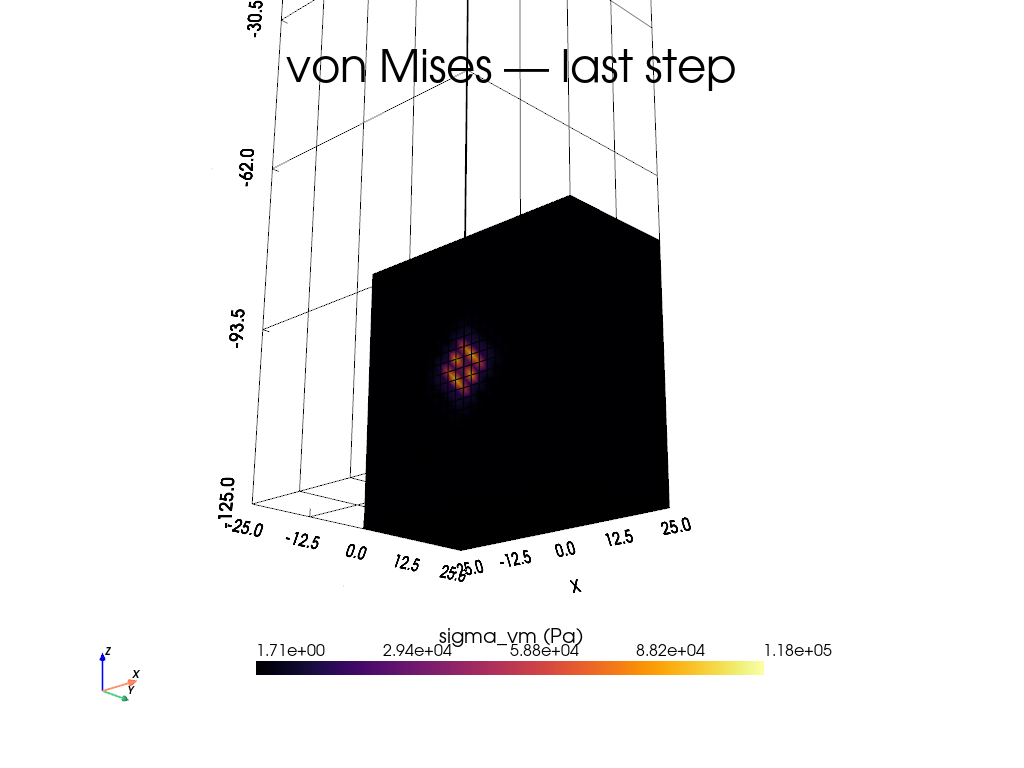

Saved to: /Volumes/Projects/Decovalex/FAULT/Decovalex_SIMTEC/_out/figs


In [37]:
pv.set_jupyter_backend("static")
pvd_path = out_dir / "genesis_HM_init.pvd"
fig_dir = out_dir / "figs"
fig_dir.mkdir(parents=True, exist_ok=True)

PRESSURE_NAME = "pressure"
SIGMA_TENSOR = "sigma"
DISP_NAME = "displacement"
CLIP_SIDE = "positive"

ms = ot.MeshSeries(pvd_path)
idx_first = 1 if len(ms) > 1 else 0
mesh_first = ms[idx_first]
mesh_last = ms[-1]

def promote_to_point(ds, name):
    if name in ds.point_data: return ds.point_data[name]
    if name in ds.cell_data:  return ds.cell_data_to_point_data(copy=True).point_data[name]
    raise KeyError(name)

def u_mag(ds):
    u = promote_to_point(ds, DISP_NAME)
    return np.linalg.norm(np.asarray(u), axis=1)

def ensure_pressure(ds):
    if PRESSURE_NAME not in ds.point_data:
        try: ds.point_data[PRESSURE_NAME] = promote_to_point(ds, PRESSURE_NAME)
        except KeyError: pass

def ensure_sigma_vm(ds):
    if "sigma_vm" in ds.point_data: return
    base = None
    for nm in (SIGMA_TENSOR, "Sigma", "stress", "Stress"):
        if nm in ds.point_data or nm in ds.cell_data:
            base = nm; break
    if base is None: return
    A = np.asarray(promote_to_point(ds, base))
    if A.ndim != 2 or A.shape[0] != ds.n_points: return
    if A.shape[1] == 6:
        sxx, syy, szz, sxy, syz, szx = [A[:, i] for i in range(6)]
    elif A.shape[1] == 9:
        sxx, syy, szz = A[:, 0], A[:, 4], A[:, 8]
        sxy = 0.5*(A[:,1]+A[:,3]); syz = 0.5*(A[:,5]+A[:,7]); szx = 0.5*(A[:,2]+A[:,6])
    else:
        return
    vm = np.sqrt(0.5*((sxx-syy)**2 + (syy-szz)**2 + (szz-sxx)**2 + 6.0*(sxy**2 + syz**2 + szx**2)))
    ds.point_data["sigma_vm"] = vm

def clipped(mesh):
    b = mesh.bounds
    o = ((b[0]+b[1])/2, (b[2]+b[3])/2, (b[4]+b[5])/2)
    invert = (CLIP_SIDE == "negative")
    h = mesh.clip(normal=(0,1,0), origin=o, invert=invert).copy()
    h.point_data["|u|"] = u_mag(h)
    ensure_pressure(h)
    ensure_sigma_vm(h)
    return h, b

def add_z0_plane(pl, bounds):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    plane = pv.Plane(center=(cx, cy, 0.0), direction=(0,0,1),
                     i_size=(xmax-xmin), j_size=(ymax-ymin),
                     i_resolution=1, j_resolution=1)
    pl.add_mesh(plane, color="black", opacity=0.08, show_edges=False)
    pl.add_mesh(pv.Line((cx, cy, 0.0), (cx, cy, zmax)), color="black", line_width=2)

def show_clip_3d(dataset, bounds, scalars, title, png_path,
                 cmap, symmetric=False, unit=None,
                 azim_deg=25, elev_deg=15, dist_factor=3.0):
    bar_title = f"{scalars}" + (f" ({unit})" if unit else "")
    sbar = dict(title=bar_title, title_font_size=20, label_font_size=16,
                fmt="%.2e" if unit in ("Pa","m") else None,
                position_x=0.25, position_y=0.12, width=0.5, height=0.05, vertical=False)

    pl = pv.Plotter(off_screen=False)
    pl.set_background("white")
    pl.add_title(title, font_size=18)
    pl.add_axes()
    pl.show_bounds(grid="front", location="outer", all_edges=True, xtitle="X", ytitle="Y", ztitle="Z")
    add_z0_plane(pl, bounds)

    if scalars not in dataset.point_data:
        return
    clim = None
    if symmetric:
        arr = np.asarray(dataset.point_data[scalars])
        vmax = np.nanpercentile(np.abs(arr), 99.5)
        if np.isfinite(vmax) and vmax > 0:
            clim = (-vmax, vmax)

    pl.add_mesh(dataset, scalars=scalars, cmap=cmap, clim=clim,
                show_edges=True, smooth_shading=True, opacity=1.0,
                scalar_bar_args=sbar, backface_params={"color":"lightgray"})

    pl.disable_parallel_projection()
    c = np.array(dataset.center)
    diag = float(np.linalg.norm(np.array(bounds[1::2]) - np.array(bounds[::2])))

    base = np.array([0.0, -1.0, 0.0]) * (dist_factor * diag)   # start “in front”
    az = np.radians(azim_deg)
    el = np.radians(elev_deg)
    Rz = np.array([[ np.cos(az), -np.sin(az), 0],
                   [ np.sin(az),  np.cos(az), 0],
                   [          0,           0, 1]])
    Rx = np.array([[1,          0,           0],
                   [0,  np.cos(el), -np.sin(el)],
                   [0,  np.sin(el),  np.cos(el)]])
    offset = Rx @ (Rz @ base)
    cam_pos = c + offset

    pl.camera.position = tuple(cam_pos)
    pl.camera.focal_point = tuple(c)
    pl.camera.up = (0, 0, 1)
    pl.show(screenshot=str(png_path))


# choose your viewing angles once
AZIM_FIRST, ELEV_FIRST = 30, 20
AZIM_LAST,  ELEV_LAST  = 40, 25

show_clip_3d(
    half_first, b_first, "|u|", "|u| — first step",
    fig_dir / "first_clip3D_u.png", cmap="Greens", unit="m",
    azim_deg=AZIM_FIRST, elev_deg=ELEV_FIRST
)
if PRESSURE_NAME in half_first.point_data:
    show_clip_3d(
        half_first, b_first, PRESSURE_NAME, "pressure — first step",
        fig_dir / "first_clip3D_pressure.png", cmap="Blues", unit="Pa",
        azim_deg=AZIM_FIRST, elev_deg=ELEV_FIRST
    )
if "sigma_vm" in half_first.point_data:
    show_clip_3d(
        half_first, b_first, "sigma_vm", "von Mises — first step",
        fig_dir / "first_clip3D_sigma_vm.png", cmap="inferno", unit="Pa",
        azim_deg=AZIM_FIRST, elev_deg=ELEV_FIRST
    )

show_clip_3d(
    half_last, b_last, "|u|", "|u| — last step",
    fig_dir / "last_clip3D_u.png", cmap="Greens", unit="m",
    azim_deg=AZIM_LAST, elev_deg=ELEV_LAST
)
if PRESSURE_NAME in half_last.point_data:
    show_clip_3d(
        half_last, b_last, PRESSURE_NAME, "pressure — last step",
        fig_dir / "last_clip3D_pressure.png", cmap="Blues", unit="Pa",
        azim_deg=AZIM_LAST, elev_deg=ELEV_LAST
    )
if "sigma_vm" in half_last.point_data:
    show_clip_3d(
        half_last, b_last, "sigma_vm", "von Mises — last step",
        fig_dir / "last_clip3D_sigma_vm.png", cmap="inferno", unit="Pa",
        azim_deg=AZIM_LAST, elev_deg=ELEV_LAST
    )

print("Saved to:", fig_dir.resolve())



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.26it/s]


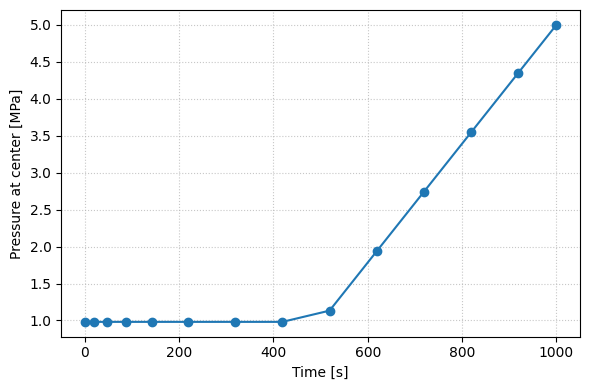

In [11]:
pvd_path = Path("_out/genesis_HM_init.pvd")
center = (0.0, 0.0, center_z)

ms = ot.MeshSeries(pvd_path).scale(time=("s", "s"))
probe = ot.MeshSeries.extract_probe(ms, [center])

t = probe.timevalues
p_pa = probe.point_data["pressure"][:, 0]
p_mpa = p_pa / 1e6

plt.figure(figsize=(6, 4))
plt.plot(t, p_mpa, marker="o", color="tab:blue")
plt.xlabel("Time [s]")
plt.ylabel("Pressure at center [MPa]")
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()
